**Task: We implemented new post recommendations algorithm for users from group 2, group 1 (and 0,3) was used as a control group. The main hypothesis is that the new algorithm in the 2nd group will lead to CTR increasing, was tested in previous task.
<br> Here the method of using new metric 'linearized likes', which should allow us to obtain more accurate result, is shown. The task is to compare the samples with a t-test by the CTR metric and the metric of linearized likes and evaluate the effect obtained**

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import hashlib
from tqdm.auto import tqdm

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
query = """


SELECT exp_group,
            user_id,
            sum(action = 'like') as likes, 
            sum(action = 'view') as views,
            likes/views as ctr,
            (SELECT sum(action = 'like')/ sum(action = 'view')
FROM simulator_20221120.feed_actions
WHERE exp_group = 1
GROUP BY exp_group) as ctrcontrol,
            (likes - ctrcontrol * views) as linearizedlikes
FROM simulator_20221120.feed_actions
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
  
GROUP BY exp_group, user_id
"""


df = ph.read_clickhouse(query, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr,ctrcontrol,linearizedlikes
0,3,115383,9,30,0.300000,0.209635,2.710937
1,1,18392,7,32,0.218750,0.209635,0.291667
2,3,123580,13,48,0.270833,0.209635,2.937500
3,2,131473,14,134,0.104478,0.209635,-14.091146
4,4,107323,5,31,0.161290,0.209635,-1.498698


**1. Сравнение 1 и 2 группы**

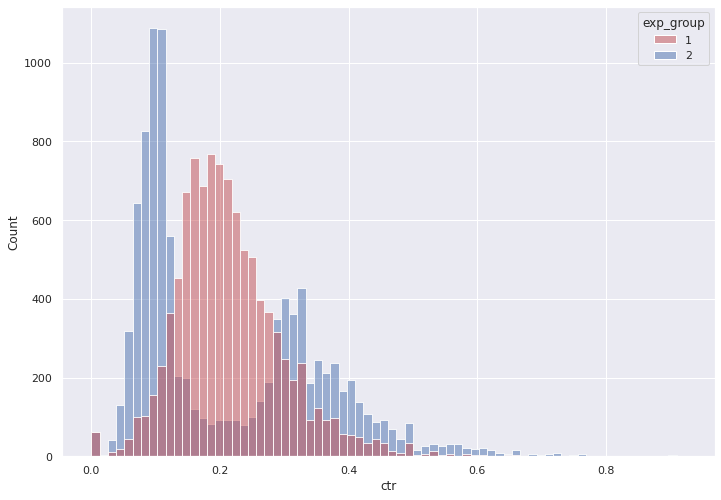

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df[(df.exp_group == 1) | (df.exp_group == 2)], 
              x='ctr', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

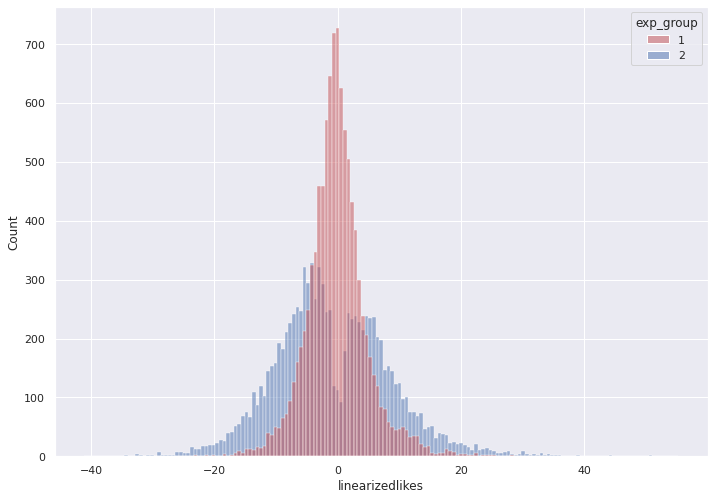

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df[(df.exp_group == 1) | (df.exp_group == 2)], 
              x='linearizedlikes', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [6]:
stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [7]:
stats.ttest_ind(df[df.exp_group == 1].linearizedlikes, df[df.exp_group == 2].linearizedlikes, equal_var=False)

Ttest_indResult(statistic=6.1087224623343594, pvalue=1.029408547799871e-09)

**Conclusion: in the case of assessing CTR, the t-test did not register the presence of differences, but when assessing by linearized likes, it was possible to spot the difference (the p-value decreased)**

**2. Comparison of 0 and 3 groups (AA test)**

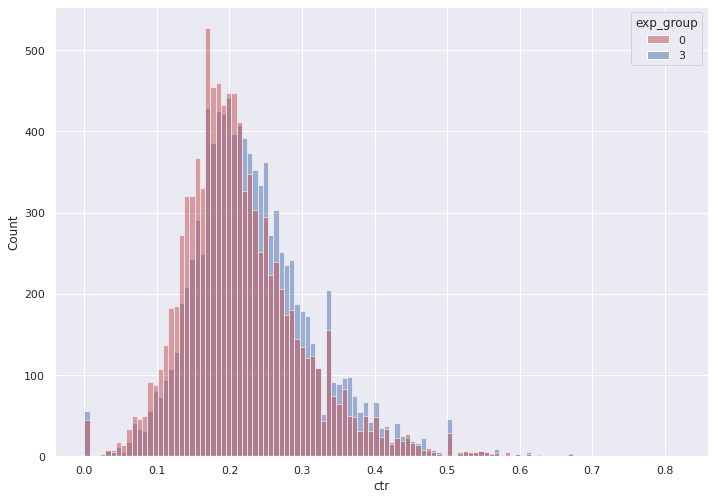

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df[(df.exp_group == 0) | (df.exp_group == 3)], 
              x='ctr', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

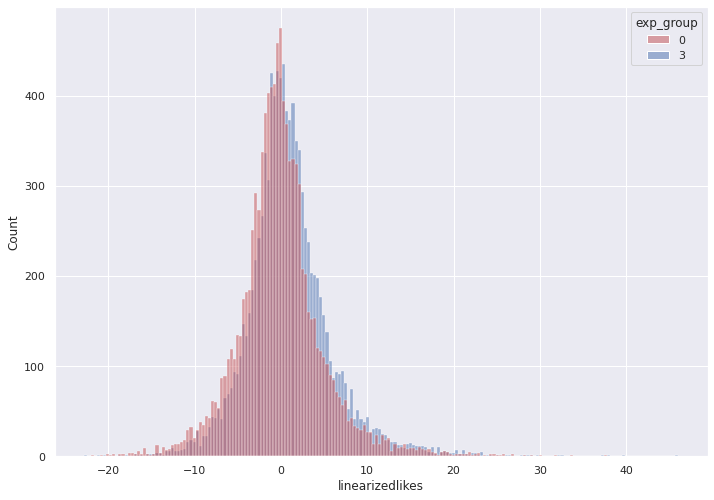

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df[(df.exp_group == 0) | (df.exp_group == 3)], 
              x='linearizedlikes', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [10]:
stats.ttest_ind(df[df.exp_group == 0].ctr, df[df.exp_group == 3].ctr, equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [11]:
stats.ttest_ind(df[df.exp_group == 0].linearizedlikes, df[df.exp_group == 3].linearizedlikes, equal_var=False)

Ttest_indResult(statistic=-15.203581918643255, pvalue=6.52453385999356e-52)

**Conclusion: in this case, when evaluating CTR, the t-test showed a statistically significant difference, but when evaluating by linearized likes, a lower p-value was obtained (so the method is more accurate)**